# Nháp

In [ ]:
import folium
import pandas as pd
from ipyleaflet import Map, Marker, FullScreenControl, LayersControl, AwesomeIcon

# Đọc dữ liệu từ tệp CSV (đổi tên tệp và cột nếu cần)
data = pd.read_csv('du_lieu_pm25_tram_thoigian.csv')

# Tạo bản đồ với vị trí trung bình của tất cả các trạm
map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
my_map = Map(center=map_center, zoom=10)

# Thêm marker cho từng trạm
markers = []
for index, row in data.iterrows():
    # Tùy chỉnh màu sắc dựa trên thông báo báo động
    icon_color = 'red' if row['BaoDong'] == 1 else 'green'
    icon = AwesomeIcon(name='circle', marker_color=icon_color, icon_color='white', spin=False)
    marker = Marker(location=(row['Latitude'], row['Longitude']), icon=icon)
    marker.popup = f"{row['Tram']} - PM2.5: {row['PM2.5']} µg/m³"
    markers.append(marker)

# Thêm markers vào bản đồ
marker_layer = folium.FeatureGroup(name='Markers')
for marker in markers:
    marker_layer.add_layer(marker)

my_map.add_layer(marker_layer)

# Thêm điều khiển trên bản đồ
my_map.add_control(FullScreenControl())
my_map.add_control(LayersControl())

# Hiển thị bản đồ
my_map


In [ ]:
import folium
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

# Tạo dữ liệu mẫu cho Hà Nội
np.random.seed(42)
n_points = 15
start_time = datetime.now() - timedelta(hours=n_points)

hanoi_data = {
    'Time': [start_time + timedelta(hours=i) for i in range(n_points)] * 10,
    'Tram': [f'Tram_{i+1}' for i in range(10) for _ in range(n_points)],
    'Latitude': np.repeat(np.random.uniform(20.75, 21.15, 10), n_points),
    'Longitude': np.repeat(np.random.uniform(105.75, 106.15, 10), n_points),
    'PM2.5': np.repeat(np.random.uniform(0, 50, 10), n_points),
    'BaoDong': np.repeat(np.random.choice([0, 1], 10), n_points)
}

hanoi_df = pd.DataFrame(hanoi_data)

# Tạo bản đồ với vị trí trung bình của Hà Nội
map_center = [hanoi_df['Latitude'].mean(), hanoi_df['Longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=10)

# Thêm marker cho từng trạm
for index, row in hanoi_df.iterrows():
    # Tùy chỉnh màu sắc dựa trên thông báo báo động
    color = 'red' if row['BaoDong'] == 1 else 'green'
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Tram']} - PM2.5: {row['PM2.5']:.2f} µg/m³",
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(my_map)

# Hiển thị bản đồ
my_map.save('map_with_pm25_data_hanoi.html')
my_map

In [ ]:
my_map

# Nạp dữ liệu

In [ ]:
!pip install torch_scatter
!pip install bresenham
!pip install torch_geometric
!pip install metpy
!pip install datetime
!pip install arrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.3/247.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils import data
import os
from collections import OrderedDict
from scipy.spatial import distance
from geopy.distance import geodesic
from bresenham import bresenham
from torch_geometric.utils import dense_to_sparse, to_dense_adj
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import arrow
from datetime import datetime

In [ ]:
import yaml

with open("/content/drive/MyDrive/data_final_project/config.yaml", 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
city_fp = "/content/drive/MyDrive/data_final_project/data/city.txt"
altitude_fp = "/content/drive/MyDrive/data_final_project/data/altitude.npy"
knowair_fp = "/content/drive/MyDrive/data_final_project/data/KnowAir.npy"

In [ ]:
results_dir = '/content/drive/MyDrive/data_final_project/results'

In [ ]:
class Graph():
    def __init__(self):
        self.dist_thres = 3
        self.alti_thres = 1200
        self.use_altitude = False

        self.altitude = self._load_altitude()
        self.nodes = self._gen_nodes()
        self.node_attr = self._add_node_attr()
        self.node_num = len(self.nodes)
        self.edge_index, self.edge_attr = self._gen_edges()
        if self.use_altitude:
            self._update_edges()
        self.edge_num = self.edge_index.shape[1]
        self.adj = to_dense_adj(torch.LongTensor(self.edge_index))[0]

    def _load_altitude(self):
        assert os.path.isfile(altitude_fp)
        altitude = np.load(altitude_fp)
        return altitude

    def _lonlat2xy(self, lon, lat, is_aliti):
        if is_aliti:
            lon_l = 100.0
            lon_r = 128.0
            lat_u = 48.0
            lat_d = 16.0
            res = 0.05
        else:
            lon_l = 103.0
            lon_r = 122.0
            lat_u = 42.0
            lat_d = 28.0
            res = 0.125
        x = np.int64(np.round((lon - lon_l - res / 2) / res))
        y = np.int64(np.round((lat_u + res / 2 - lat) / res))
        return x, y

    def _gen_nodes(self):
        nodes = OrderedDict()
        with open(city_fp, 'r') as f:
            for line in f:
                idx, city, lon, lat = line.rstrip('\n').split(' ')
                idx = int(idx)
                lon, lat = float(lon), float(lat)
                x, y = self._lonlat2xy(lon, lat, True)
                altitude = self.altitude[y, x]
                nodes.update({idx: {'city': city, 'altitude': altitude, 'lon': lon, 'lat': lat}})
        return nodes

    def _add_node_attr(self):
        node_attr = []
        altitude_arr = []
        for i in self.nodes:
            altitude = self.nodes[i]['altitude']
            altitude_arr.append(altitude)
        altitude_arr = np.stack(altitude_arr)
        node_attr = np.stack([altitude_arr], axis=-1)
        return node_attr

    def traverse_graph(self):
        lons = []
        lats = []
        citys = []
        idx = []
        for i in self.nodes:
            idx.append(i)
            city = self.nodes[i]['city']
            lon, lat = self.nodes[i]['lon'], self.nodes[i]['lat']
            lons.append(lon)
            lats.append(lat)
            citys.append(city)
        return idx, citys, lons, lats

    def gen_lines(self):

        lines = []
        for i in range(self.edge_index.shape[1]):
            src, dest = self.edge_index[0, i], self.edge_index[1, i]
            src_lat, src_lon = self.nodes[src]['lat'], self.nodes[src]['lon']
            dest_lat, dest_lon = self.nodes[dest]['lat'], self.nodes[dest]['lon']
            lines.append(([src_lon, dest_lon], [src_lat, dest_lat]))

        return lines

    def _gen_edges(self):
        coords = []
        lonlat = {}
        for i in self.nodes:
            coords.append([self.nodes[i]['lon'], self.nodes[i]['lat']])
        dist = distance.cdist(coords, coords, 'euclidean')
        adj = np.zeros((self.node_num, self.node_num), dtype=np.uint8)
        adj[dist <= self.dist_thres] = 1
        assert adj.shape == dist.shape
        dist = dist * adj
        edge_index, dist = dense_to_sparse(torch.tensor(dist))
        edge_index, dist = edge_index.numpy(), dist.numpy()

        direc_arr = []
        dist_kilometer = []
        for i in range(edge_index.shape[1]):
            src, dest = edge_index[0, i], edge_index[1, i]
            src_lat, src_lon = self.nodes[src]['lat'], self.nodes[src]['lon']
            dest_lat, dest_lon = self.nodes[dest]['lat'], self.nodes[dest]['lon']
            src_location = (src_lat, src_lon)
            dest_location = (dest_lat, dest_lon)
            dist_km = geodesic(src_location, dest_location).kilometers
            v, u = src_lat - dest_lat, src_lon - dest_lon

            u = u * units.meter / units.second
            v = v * units.meter / units.second
            direc = mpcalc.wind_direction(u, v)._magnitude

            direc_arr.append(direc)
            dist_kilometer.append(dist_km)

        direc_arr = np.stack(direc_arr)
        dist_arr = np.stack(dist_kilometer)
        attr = np.stack([dist_arr, direc_arr], axis=-1)

        return edge_index, attr

    def _update_edges(self):
        edge_index = []
        edge_attr = []
        for i in range(self.edge_index.shape[1]):
            src, dest = self.edge_index[0, i], self.edge_index[1, i]
            src_lat, src_lon = self.nodes[src]['lat'], self.nodes[src]['lon']
            dest_lat, dest_lon = self.nodes[dest]['lat'], self.nodes[dest]['lon']
            src_x, src_y = self._lonlat2xy(src_lon, src_lat, True)
            dest_x, dest_y = self._lonlat2xy(dest_lon, dest_lat, True)
            points = np.asarray(list(bresenham(src_y, src_x, dest_y, dest_x))).transpose((1,0))
            altitude_points = self.altitude[points[0], points[1]]
            altitude_src = self.altitude[src_y, src_x]
            altitude_dest = self.altitude[dest_y, dest_x]
            if np.sum(altitude_points - altitude_src > self.alti_thres) < 3 and \
               np.sum(altitude_points - altitude_dest > self.alti_thres) < 3:
                edge_index.append(self.edge_index[:,i])
                edge_attr.append(self.edge_attr[i])

        self.edge_index = np.stack(edge_index, axis=1)
        self.edge_attr = np.stack(edge_attr, axis=0)

In [ ]:
class HazeData(data.Dataset):

    def __init__(self, graph,
                       hist_len=1,
                       pred_len=24,
                       dataset_num=1,
                       flag='Train',
                       ):

        if flag == 'Train':
            start_time_str = 'train_start'
            end_time_str = 'train_end'
        elif flag == 'Val':
            start_time_str = 'val_start'
            end_time_str = 'val_end'
        elif flag == 'Test':
            start_time_str = 'test_start'
            end_time_str = 'test_end'
        else:
            raise Exception('Wrong Flag!')

        self.start_time = self._get_time(config['dataset'][dataset_num][start_time_str])
        self.end_time = self._get_time(config['dataset'][dataset_num][end_time_str])
        self.data_start = self._get_time(config['dataset']['data_start'])
        self.data_end = self._get_time(config['dataset']['data_end'])

        self.knowair_fp = "/content/drive/MyDrive/data_final_project/data/KnowAir.npy" # file_dir['knowair_fp']

        self.graph = graph

        self._load_npy()
        self._gen_time_arr()
        self._process_time()
        self._process_feature()
        self.feature = np.float32(self.feature)
        self.pm25 = np.float32(self.pm25)
        self._calc_mean_std()
        seq_len = hist_len + pred_len
        self._add_time_dim(seq_len)
        self._norm()

    def _norm(self):
        self.feature = (self.feature - self.feature_mean) / self.feature_std
        self.pm25 = (self.pm25 - self.pm25_mean) / self.pm25_std

    def _add_time_dim(self, seq_len):

        def _add_t(arr, seq_len):
            t_len = arr.shape[0]
            assert t_len > seq_len
            arr_ts = []
            for i in range(seq_len, t_len):
                arr_t = arr[i-seq_len:i]
                arr_ts.append(arr_t)
            arr_ts = np.stack(arr_ts, axis=0)
            return arr_ts

        self.pm25 = _add_t(self.pm25, seq_len)
        self.feature = _add_t(self.feature, seq_len)
        self.time_arr = _add_t(self.time_arr, seq_len)

    def _calc_mean_std(self):
        self.feature_mean = self.feature.mean(axis=(0,1))
        self.feature_std = self.feature.std(axis=(0,1))
        self.wind_mean = self.feature_mean[-2:]
        self.wind_std = self.feature_std[-2:]
        self.pm25_mean = self.pm25.mean()
        self.pm25_std = self.pm25.std()

    def _process_feature(self):
        metero_var = config['data']['metero_var']

        metero_use = config['experiments']['metero_use']

        metero_idx = [metero_var.index(var) for var in metero_use]
        self.feature = self.feature[:,:,metero_idx]

        # Có thể phải sửa ở đây
        u = self.feature[:, :, -2] * units.meter / units.second
        v = self.feature[:, :, -1] * units.meter / units.second
        speed = 3.6 * mpcalc.wind_speed(u, v)._magnitude
        direc = mpcalc.wind_direction(u, v)._magnitude

        h_arr = []
        w_arr = []
        for i in self.time_arrow:
            h_arr.append(i.hour)
            w_arr.append(i.isoweekday())
        h_arr = np.stack(h_arr, axis=-1)
        w_arr = np.stack(w_arr, axis=-1)
        h_arr = np.repeat(h_arr[:, None], self.graph.node_num, axis=1)
        w_arr = np.repeat(w_arr[:, None], self.graph.node_num, axis=1)

        self.feature = np.concatenate([self.feature, h_arr[:, :, None], w_arr[:, :, None],
                                       speed[:, :, None], direc[:, :, None]
                                       ], axis=-1)

    def _process_time(self):
        start_idx = self._get_idx(self.start_time)
        end_idx = self._get_idx(self.end_time)
        self.pm25 = self.pm25[start_idx: end_idx+1, :]
        self.feature = self.feature[start_idx: end_idx+1, :]
        self.time_arr = self.time_arr[start_idx: end_idx+1]
        self.time_arrow = self.time_arrow[start_idx: end_idx + 1]

    def _gen_time_arr(self):
        self.time_arrow = []
        self.time_arr = []
        for time_arrow in arrow.Arrow.interval('hour', self.data_start, self.data_end.shift(hours=+3), 3):
            self.time_arrow.append(time_arrow[0])
            self.time_arr.append(time_arrow[0].timestamp())
        self.time_arr = np.stack(self.time_arr, axis=-1)

    def _load_npy(self):
        self.knowair = np.load(self.knowair_fp)
        self.feature = self.knowair[:,:,:-1]
        self.pm25 = self.knowair[:,:,-1:]

    def _get_idx(self, t):
        t0 = self.data_start
        return int((t.timestamp() - t0.timestamp()) / (60 * 60 * 3))

    def _get_time(self, time_yaml):
        arrow_time = arrow.get(datetime(*time_yaml[0]), time_yaml[1])
        return arrow_time

    def __len__(self):
        return len(self.pm25)

    def __getitem__(self, index):
        return self.pm25[index], self.feature[index], self.time_arr[index]

In [ ]:
hist_len = 1 #config['train']['hist_len']
pred_len = 24 #config['train']['pred_len']
dataset_num = 1
graph = Graph()
test_data = HazeData(graph, hist_len, pred_len, dataset_num, flag='Test')

In [ ]:
adj = test_data.graph.adj.numpy()
adj

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]], dtype=float32)

In [ ]:
indices = np.where(adj == 1)

In [ ]:
index_pairs = list(zip(*indices))
print(len(index_pairs))
index_pairs = set(tuple(sorted(pair)) for pair in index_pairs)
print(len(index_pairs))

3938
1969


In [ ]:
list(index_pairs)[0]

(12, 123)

# Trực quan kết quả

In [ ]:
import os
import numpy as np

In [ ]:
def visual_result(path_result):
    label_result = np.load(os.path.join(path_result, 'label.npy'))
    predict_result = np.load(os.path.join(path_result, 'predict.npy'))
    time_result = np.load(os.path.join(path_result,'time.npy'))

    def get_predict_and_label(predict_epoch, label_epoch):
        predict_mean = np.mean(predict_result, axis=2)
        label_mean = np.mean(label_result, axis=2)
        return predict_mean, label_mean

    predict_mean, label_mean = get_predict_and_label(predict_result, label_result)

    def plot_label_predict(label, predict, save_path):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(label, label='Ground truth', color='blue', alpha=0.7)
        plt.plot(predict, label='Predict', color='red', alpha=0.7)
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.title('Ground truth vs. Predict')
        plt.legend()
        plt.grid(True)
        plt.savefig(save_path)

    i = 2800
    plot_label_predict(np.concatenate((predict_mean[i], predict_mean[24 * 1 + i], predict_mean[48 + i]), axis=0),
                    np.concatenate((label_mean[i], label_mean[24 * 1 + i], label_mean[48 + i]), axis=0),
                    os.path.join(path_result, 'Ground_truth_vs_Predict.png'))

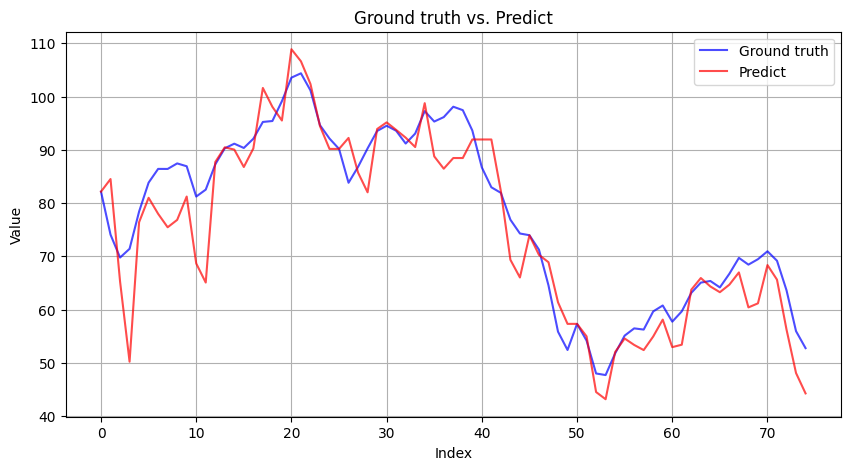

In [ ]:
path_result = "/content/drive/MyDrive/data_final_project/results/1_24/1/PM25_GNN/2024_02_25_12_43_17/05"
visual_result(path_result)

In [ ]:
label_result = np.load(os.path.join(path_result, 'label.npy'))
predict_result = np.load(os.path.join(path_result, 'predict.npy'))
time_result = np.load(os.path.join(path_result,'time.npy'))

In [ ]:
np.max(label_result)

867.0

In [ ]:
np.mean(predict_result)

45.281895

In [ ]:
import pandas as pd
rmse = [19.76, 19.92, 19.95, 19.95, 20.06, 19.94, 19.76, 19.82, 19.85, 19.77]
data_series = pd.Series(rmse)
statistics = data_series.describe()
print(statistics)

count    10.000000
mean     19.878000
std       0.101522
min      19.760000
25%      19.782500
50%      19.885000
75%      19.947500
max      20.060000
dtype: float64


# Trực quan Graph

In [ ]:
pip install matplotlib geopandas shapely

In [ ]:
import pandas as pd

# Giả sử nội dung file được lưu trong biến `data`
with open('/content/drive/MyDrive/data_final_project/data/city.txt') as file:
  data = file.read()

# Chuyển đổi dữ liệu thành DataFrame
df = pd.DataFrame([line.split() for line in data.split('\n') if line], columns=['Index', 'Tram', 'Longitude', 'Latitude'])

# Chuyển đổi DataFrame thành JSON
json_data = df.to_json(orient='records')

print(json_data)

[{"Index":"0","Tram":"Beijing","Longitude":"116.39824999999998","Latitude":"40.045975000000006"},{"Index":"1","Tram":"Tianjin","Longitude":"117.32216666666666","Latitude":"39.07768333333333"},{"Index":"2","Tram":"Shijiazhuang","Longitude":"114.49317142857144","Latitude":"38.033628571428565"},{"Index":"3","Tram":"Tangshan","Longitude":"118.18291666666666","Latitude":"39.64495333333334"},{"Index":"4","Tram":"Qinhuangdao","Longitude":"119.606875","Latitude":"39.936249999999994"},{"Index":"5","Tram":"Handan","Longitude":"114.51387499999998","Latitude":"36.607859999999995"},{"Index":"6","Tram":"Baoding","Longitude":"115.4852","Latitude":"38.876266666666666"},{"Index":"7","Tram":"Zhangjiakou","Longitude":"114.90084999999999","Latitude":"40.80275"},{"Index":"8","Tram":"Chengde","Longitude":"117.92774","Latitude":"40.96416"},{"Index":"9","Tram":"Langfang","Longitude":"116.7151","Latitude":"39.52605"},{"Index":"10","Tram":"Cangzhou","Longitude":"116.87156666666668","Latitude":"38.31576666666667

In [ ]:
import json
json_data = json.loads(json_data)

In [ ]:
import folium
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

# Tạo dữ liệu mẫu cho Hà Nội
np.random.seed(42)
n_points = 184
start_time = datetime.now() - timedelta(hours=n_points)

hanoi_data = {
    # 'Time': [start_time + timedelta(hours=i) for i in range(n_points)] * 10,
    'Index': [item['Index'] for item in json_data],
    'Tram': [item['Tram'] for item in json_data],
    'Latitude': [float(item['Latitude']) for item in json_data],
    'Longitude': [float(item['Longitude']) for item in json_data],
    'PM2.5': np.random.uniform(0, 50, 184),
    'BaoDong': np.random.choice([0, 0], 184)
}

hanoi_df = pd.DataFrame(hanoi_data)

# Tạo bản đồ với vị trí trung bình của Hà Nội
map_center = [hanoi_df['Latitude'].mean(), hanoi_df['Longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=10)

# Thêm marker cho từng trạm
for index, row in hanoi_df.iterrows():
    # Tùy chỉnh màu sắc dựa trên thông báo báo động
    color = 'red' if row['BaoDong'] == 1 else 'green'
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Tram']} - PM2.5: {row['PM2.5']:.2f} µg/m³",
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(my_map)

# Danh sách các cặp trạm cần nối
pairs = sorted(list(index_pairs))

# Thêm đường nối giữa các cặp trạm
for pair in pairs:
    tram1 = hanoi_df[hanoi_df['Index'] == str(pair[0])].iloc[0]
    tram2 = hanoi_df[hanoi_df['Index'] == str(pair[1])].iloc[0]
    folium.PolyLine(
        locations=[[tram1['Latitude'], tram1['Longitude']], [tram2['Latitude'], tram2['Longitude']]],
        color='blue'
    ).add_to(my_map)

# Hiển thị bản đồ
my_map.save('map_with_pm25_data_hanoi.html')
my_map